In [94]:
import pandas as pd
import classy as Class
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)
print(As)

standard_params = {
    "omega_b": 0.02242,
    "omega_cdm": 0.11933,
    "n_s": 0.9665,
    "tau_reio": 0.0561,
    "ln10^{10}A_s": ln10e10As,
    #"100*theta_s": 1.04,
    "H0": 67.66
}

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True
fsize=16

common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 1,
                   'lensing': 'yes',
                   'xe_pert_type': 'none'
                  }

#LCDM parameters
for name, value in standard_params.items():
    common_settings.update({name: value})

pr_cover_tau = 0.004
precision_settings = {"start_sources_at_tau_c_over_tau_h": pr_cover_tau}

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)

2.105209331337507e-09


True

In [95]:
M.compute()

fiducial_thermo = M.get_thermodynamics()
fiducial = fiducial_thermo["x_fid"]

Reading input parameters
 -> matched budget equations by adjusting Omega_Lambda = 0.690267


In [96]:
def create_pivot_redshifts(N, start, stop):
    pivots = np.linspace(start=start, stop=stop, num=N+2)
    free_pivots = pivots[1:-1]

    str_pivots = ["{:.4f}".format(p) for p in pivots]
    str_pivots = ",".join(str_pivots)

    return [pivots, free_pivots, str_pivots]

num_control_points = 4
zmin_pert = 650
zmax_pert = 1400

pivot_info = create_pivot_redshifts(num_control_points, zmin_pert, zmax_pert)

print(pivot_info[2])

common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'control',
                   'xe_pert_num': num_control_points+2,
                   'zmin_pert': zmin_pert,
                   'zmax_pert': zmax_pert,
                   'xe_control_pivots': pivot_info[2]
                  }

650.0000,800.0000,950.0000,1100.0000,1250.0000,1400.0000


In [97]:
df = pd.read_csv("/Users/gabe/projects/recombination/data/nldr_result_multi.csv")
df.columns = ['weight', 'minuslogpost', 'logA', 'n_s', 'omega_b', 'omega_cdm', 'tau_reio', 'q_1', 'q_2', 'q_3', 'q_4', 'A_planck', 'clamp', 'chi2__CMB', 'minuslogprior', 'minuslogprior__0', 'minuslogprior__control_point_joint_prior', 'chi2', 'chi2__planck_2018_lowl.TT', 'chi2__planck_2018_lowl.EE', 'chi2__planck_2018_highl_plik.TTTEEE_lite', 'h']

In [98]:
df

,weight,minuslogpost,logA,n_s,omega_b,omega_cdm,tau_reio,q_1,q_2,q_3,...,clamp,chi2__CMB,minuslogprior,minuslogprior__0,minuslogprior__control_point_joint_prior,chi2,chi2__planck_2018_lowl.TT,chi2__planck_2018_lowl.EE,chi2__planck_2018_highl_plik.TTTEEE_lite,h
0,1.0,2464.318643,3.049737,0.957909,0.021796,0.122022,0.065167,-1.102381,1.717121,1.371476,...,1.853021,4872.302474,28.167406,-3.912502,32.079908,4872.302474,21.530621,401.972883,4448.798971,0.520513


In [99]:
xe_pert_funcs = []
xe_fid_funcs = []
H0s = []
viz_funcs = []
z_list = []
idx=0
for index,row in df.iterrows():
    print(row["logA"])
    cps = [0.0, row["q_1"], row["q_2"], row["q_3"], row["q_4"], 0.0]
    cps_str = ",".join([str(c) for c in cps])
    params = {
    "omega_b": row["omega_b"],
    "omega_cdm": row["omega_cdm"],
    "n_s": row["n_s"],
    "tau_reio": row["tau_reio"],
    "ln10^{10}A_s": row["logA"],
    #"100*theta_s": 1.04,
    "H0": 100*row["h"],
    "xe_control_points": cps_str
    }
    common_settings.update(params)
    M.set(common_settings)
    M.compute(level=["thermodynamics"])
    thermo = M.get_thermodynamics()
    z_list.append(thermo["z"])
    xe_pert_funcs.append(thermo['xe_pert'])
    xe_fid_funcs.append(thermo["x_fid"])
    viz_funcs.append(thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"])
    H0s.append(100*row["h"])
    idx+=1


3.0497373207993976


[52.05128205]


/var/folders/dx/56r119096g71nr7d270292b80000gn/T/ipykernel_4368/2918690125.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


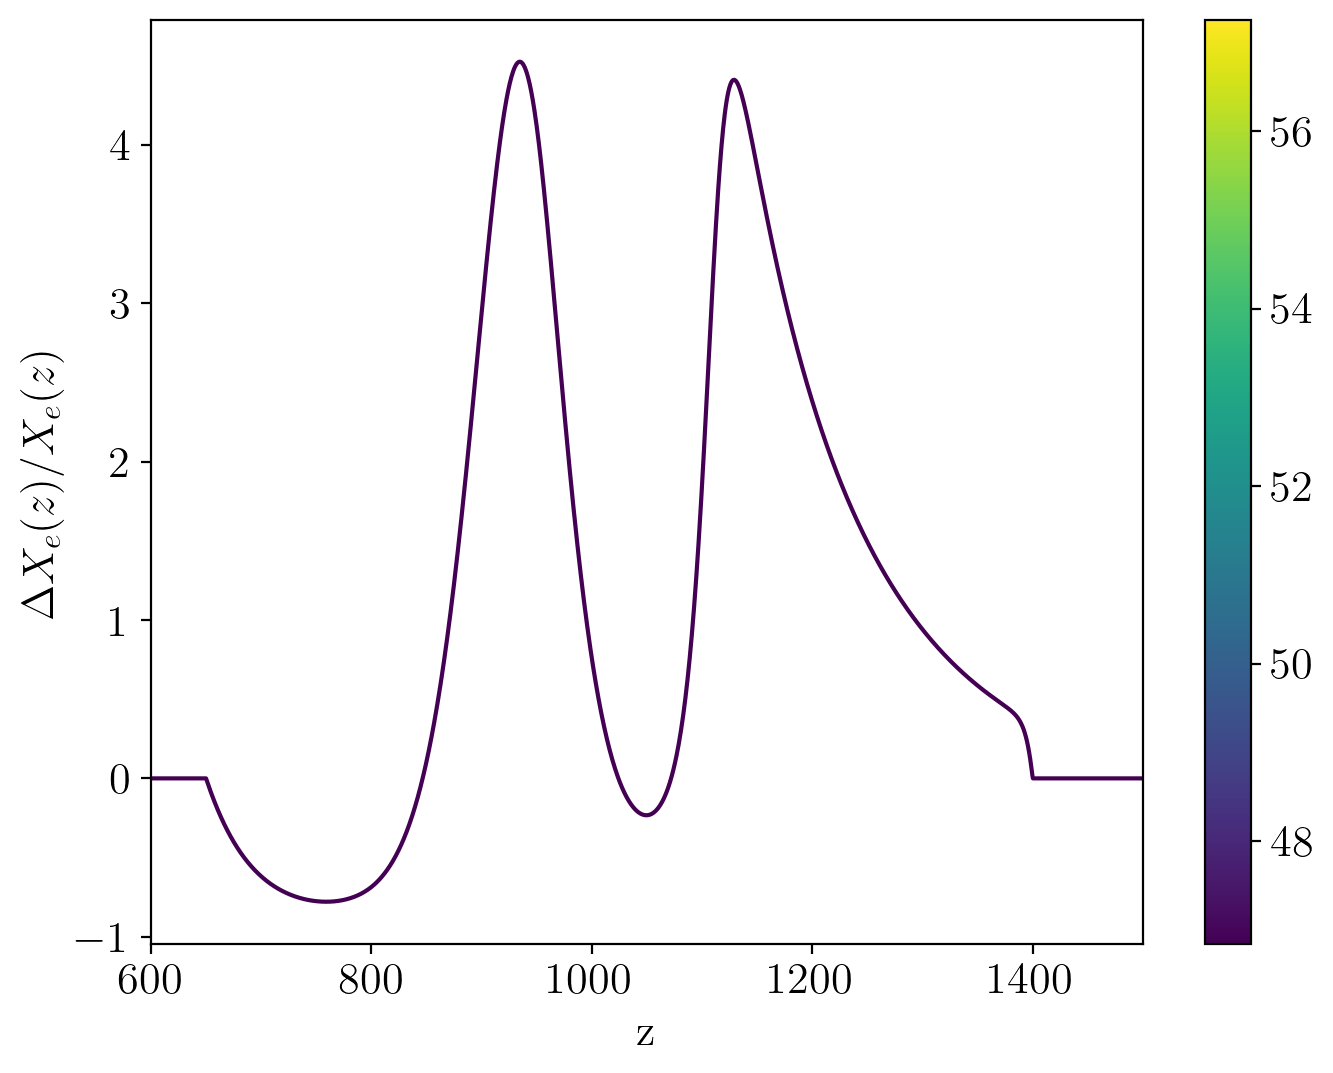

In [100]:
fig,ax = plt.subplots()
H0s = np.array(H0s)
print(H0s)
norm = mpl.colors.Normalize(vmin=H0s.min(), vmax=H0s.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap.set_array([])

for i,xe in enumerate(xe_pert_funcs):
    ax.plot(z_list[0], xe/fiducial, color=cmap.to_rgba(H0s[i]))
ax.set_xlim([600, 1500])
ax.set_xlabel("z")
ax.set_ylabel(r"$\Delta X_e(z) / X_e(z)$")
fig.colorbar(cmap)
#plt.show()
plt.savefig("../results/nldr_2.pdf", dpi=300, bbox_inches='tight')

/var/folders/dx/56r119096g71nr7d270292b80000gn/T/ipykernel_60459/2256346025.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


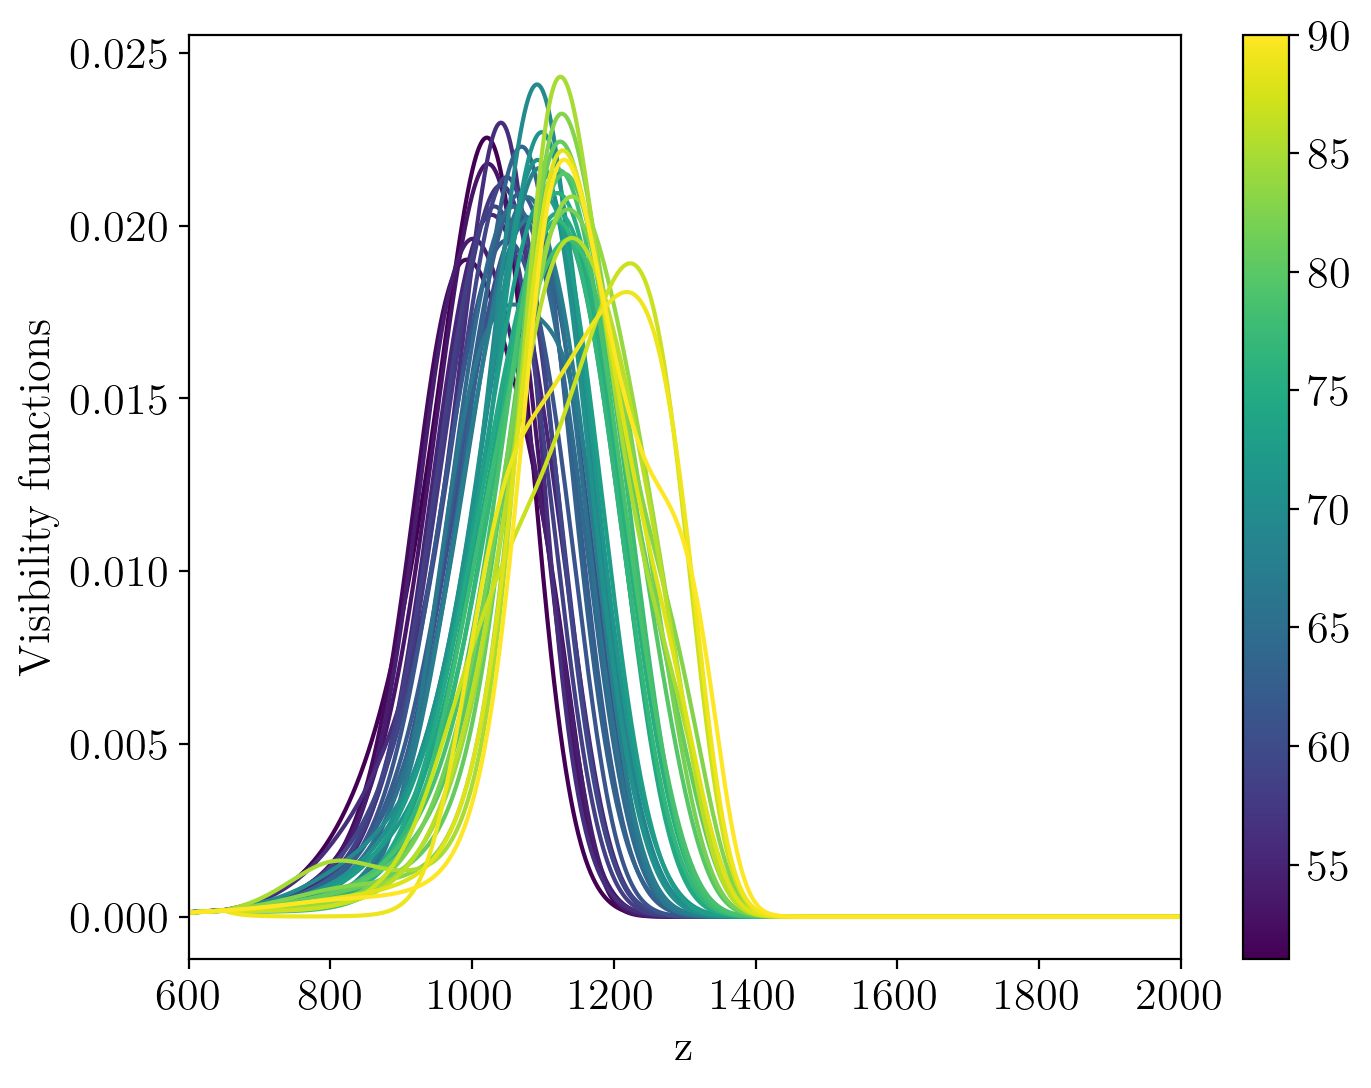

In [202]:
fig,ax = plt.subplots()
H0s = np.array(H0s)

norm = mpl.colors.Normalize(vmin=H0s.min(), vmax=H0s.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap.set_array([])

for i,viz in enumerate(viz_funcs):
    ax.plot(z_list[0], viz, color=cmap.to_rgba(H0s[i]))
ax.set_xlim([600, 2000])
ax.set_xlabel("z")
ax.set_ylabel("Visibility functions")
fig.colorbar(cmap)
plt.show()
#plt.savefig("../results/nldr_viz_1.pdf", dpi=300, bbox_inches='tight')

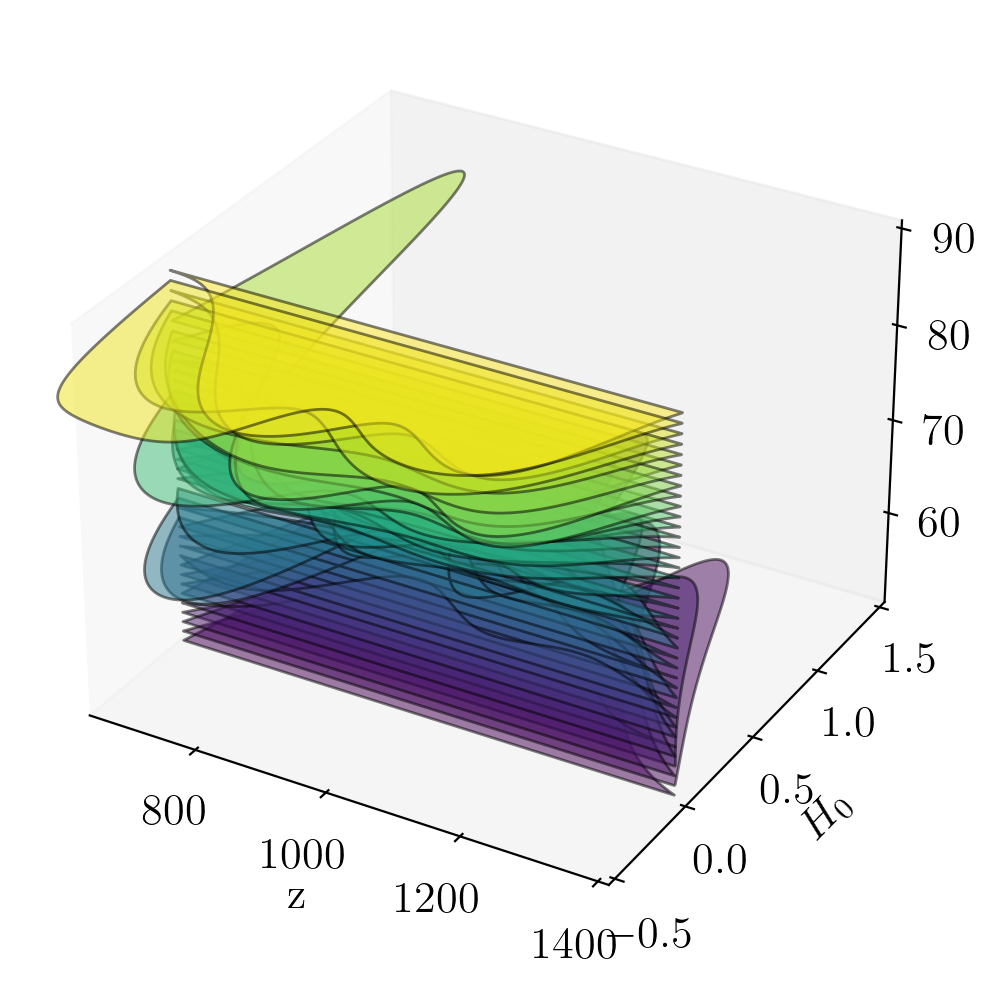

In [209]:
from matplotlib.collections import PolyCollection
import math

# Fixing random state for reproducibility
ax = plt.figure().add_subplot(projection='3d')

a = 0

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0), *zip(x, y), (x[-1], 0)]

test = np.where(z_list[0]<zmin_pert, 1, 0)
ind_lowz = np.argwhere(np.diff(test)==-1)[0][0]
test = np.where(z_list[0]>zmax_pert, 1, 0)
ind_hiz = np.argwhere(np.diff(test)==1)[0][0]

# verts[i] is a list of (x, y) pairs defining polygon i.
verts = [polygon_under_graph(z_list[0][ind_lowz:ind_hiz], x[ind_lowz:ind_hiz]/fiducial[ind_lowz:ind_hiz])
         for x in xe_pert_funcs[a:]]

facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))

#poly = PolyCollection(verts,facecolor='white', alpha=0.5)
poly = PolyCollection(verts,facecolor=facecolors[::-1], alpha=0.5)
poly.set_edgecolor('black')
ax.add_collection3d(poly, zs=H0s[a:], zdir='z')

ax.set(xlim=(650, 1400), zlim=(H0s.min(), H0s.max()), ylim=(-0.5, 1.5),
       xlabel='z', ylabel=r'$H_0$', zlabel='')
ax.grid(False)
plt.show()